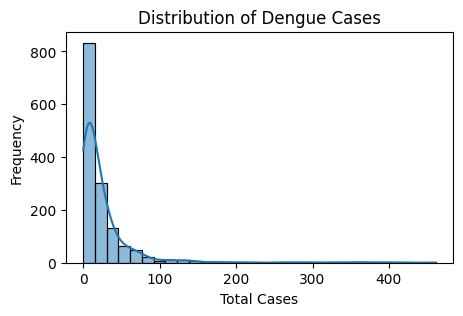

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
# Load the training labels dataset
df_train_labels = pd.read_csv('dengue_labels_train.csv')
# Distribution of total_cases
plt.figure(figsize=(5, 3))
sns.histplot(df_train_labels['total_cases'], bins=30, kde=True)
plt.title('Distribution of Dengue Cases')
plt.xlabel('Total Cases')
plt.ylabel('Frequency')
plt.show()

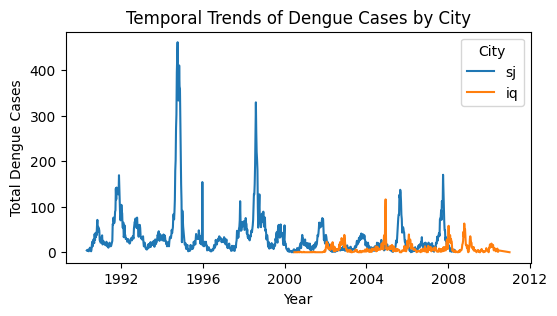

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_merge_data(features_path, labels_path):
    df_train_features = pd.read_csv(features_path)
    df_train_labels = pd.read_csv(labels_path)
    df_merged = pd.merge(df_train_features[['city', 'year', 'weekofyear']], df_train_labels, on=['city', 'year', 'weekofyear'])
    return df_merged

def convert_date(df):
    df['date'] = pd.to_datetime(df['year'].astype(str), format='%Y') + pd.to_timedelta((df['weekofyear']-1) * 7, unit='d')
    return df

def plot_dengue_trends(df):
    plt.figure(figsize=(6, 3))
    sns.lineplot(data=df, x='date', y='total_cases', hue='city')
    plt.title('Temporal Trends of Dengue Cases by City')
    plt.xlabel('Year')
    plt.ylabel('Total Dengue Cases')
    plt.legend(title='City')
    plt.show()

# Define file paths
features_path = 'dengue_features_train.csv'
labels_path = 'dengue_labels_train.csv'

# Process data
df_merged = load_and_merge_data(features_path, labels_path)
df_merged = convert_date(df_merged)

# Visualize data
plot_dengue_trends(df_merged)


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def load_data(features_path, labels_path, test_path):
    df_train_X = pd.read_csv(features_path)
    df_train_Y = pd.read_csv(labels_path)['total_cases']
    df_test = pd.read_csv(test_path)
    return df_train_X, df_train_Y, df_test

def preprocess_data(df_train_X, df_test):
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    df_train_X_imputed = pd.DataFrame(imputer.fit_transform(df_train_X.select_dtypes(exclude='object')))
    df_test_imputed = pd.DataFrame(imputer.transform(df_test.select_dtypes(exclude='object')))

    # Encode categorical variables
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    df_train_X_encoded = pd.DataFrame(encoder.fit_transform(df_train_X[['city']]))
    df_test_encoded = pd.DataFrame(encoder.transform(df_test[['city']]))

    # Reset index to avoid concatenation issues
    df_train_X_imputed.reset_index(drop=True, inplace=True)
    df_train_X_encoded.reset_index(drop=True, inplace=True)
    df_test_imputed.reset_index(drop=True, inplace=True)
    df_test_encoded.reset_index(drop=True, inplace=True)

    # Concatenate processed numerical and categorical features
    X_train_processed = pd.concat([df_train_X_imputed, df_train_X_encoded], axis=1)
    X_test_processed = pd.concat([df_test_imputed, df_test_encoded], axis=1)

    return X_train_processed, X_test_processed

def train_and_evaluate(X_train, y_train, X_val, y_val):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    mae = mean_absolute_error(y_val, predictions)
    print(f'Mean Absolute Error: {mae}')
    return model

def predict_and_prepare_submission(model, X_test, df_test):
    test_predictions = model.predict(X_test)
    submission = df_test[['city', 'year', 'weekofyear']].copy()
    submission['total_cases'] = test_predictions.astype(int)  # Ensure total_cases is an integer
    return submission

# Main execution flow
features_path = 'dengue_features_train.csv'
labels_path = 'dengue_labels_train.csv'
test_path = 'dengue_features_test.csv'

df_train_X, df_train_Y, df_test = load_data(features_path, labels_path, test_path)
X_train_processed, X_test_processed = preprocess_data(df_train_X, df_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_processed, df_train_Y, test_size=0.2, random_state=42)
model = train_and_evaluate(X_train, y_train, X_val, y_val)
submission = predict_and_prepare_submission(model, X_test_processed, df_test)
submission.to_csv('dengue_submission.csv', index=False)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Mean Absolute Error: 14.599109589041097


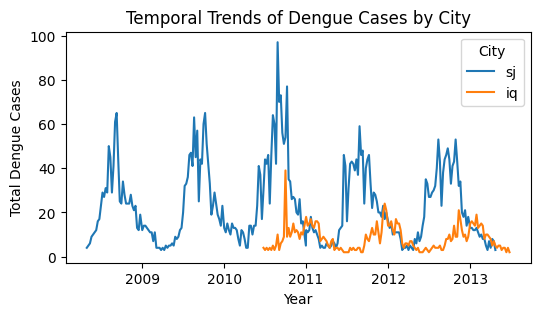

In [33]:
df_train_predicted = pd.read_csv('dengue_submission.csv')


# Convert 'year' and 'weekofyear' to an approximate datetime object marking the week's start
df_train_predicted['date'] = pd.to_datetime(df_train_predicted['year'].astype(str), format='%Y') + \
pd.to_timedelta((df_train_predicted['weekofyear']-1) * 7, unit='d')

# Now let's plot the temporal trends
plt.figure(figsize=(6, 3))
sns.lineplot(data=df_train_predicted, x='date', y='total_cases', hue='city')
plt.title('Temporal Trends of Dengue Cases by City')
plt.xlabel('Year')
plt.ylabel('Total Dengue Cases')
plt.legend(title='City')
plt.show()

Mean Squared Error: 1765.0784498073635


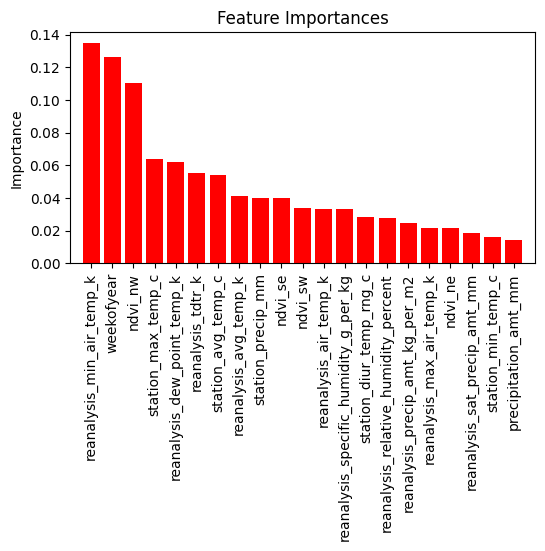

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load and prepare data
def load_and_prepare_data(features_path, labels_path):
    features_data = pd.read_csv(features_path)
    labels_data = pd.read_csv(labels_path)
    merged_data = pd.merge(features_data, labels_data, on=['city', 'year', 'weekofyear'])
    selected_features = merged_data
    selected_features = selected_features.drop(columns=['city', 'year', 'week_start_date', 'total_cases'])
    selected_features = selected_features.fillna(selected_features.mean())
    labels = merged_data['total_cases']
    return selected_features, labels

# Function to plot feature importances
def plot_feature_importances(importances, feature_names):
    indices = np.argsort(importances)[::-1]
    sorted_feature_names = [feature_names[i] for i in indices]
    plt.figure(figsize=(6, 3))
    plt.title('Feature Importances')
    plt.bar(range(len(importances)), importances[indices], color="r", align="center")
    plt.xticks(range(len(importances)), sorted_feature_names, rotation=90)
    plt.xlim([-1, len(importances)])
    plt.ylabel('Importance')
    plt.show()

# Function to Plot actual vs predicted results
def plot_actual_vs_predicted(actual, predicted):
    plt.figure(figsize=(6, 3))
    plt.scatter(actual, predicted, alpha=0.5)
    plt.xlabel('Actual Cases')
    plt.ylabel('Predicted Cases')
    plt.title('Actual vs. Predicted Dengue Cases')
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2)  # Diagonal line
    plt.grid(True)
    plt.show()

# Load data
features_path = 'dengue_features_train.csv'
labels_path = 'dengue_labels_train.csv'
X, y = load_and_prepare_data(features_path, labels_path)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Predict on the test data
y_pred = random_forest_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Get feature importances
feature_importances = random_forest_model.feature_importances_
feature_names = X.columns.tolist()

# Plot feature importances
plot_feature_importances(feature_importances, feature_names)


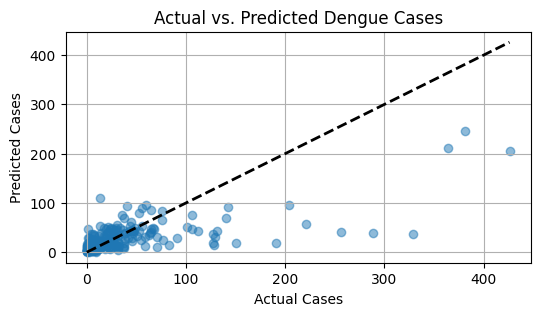

In [36]:
# Function to Plot actual vs predicted results
plot_actual_vs_predicted(y_test, y_pred)